### Facebook AI - Clustering Demo

In [454]:
import os
import sys
import faiss
import numpy
import sklearn
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from scipy.stats import mode

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

from sklearn.metrics import classification_report


### Set up FAISS KMeans

In [389]:
class FaissKMeans:
    def __init__(self, n_clusters=2, n_init=4, max_iter=3000):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.verbose = True

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init,
                                  verbose=self.verbose)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]

### Setup SKlearn Clustering

In [390]:
class SklearnKMeans:
    def __init__(self, n_clusters=2, n_init=4, max_iter=3000):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = KMeans(init="k-means++", n_clusters=self.n_clusters, n_init=4,
                random_state=0)
        self.kmeans.fit(X)
        self.cluster_centers_ = self.kmeans.cluster_centers_
        
    def predict(self, X):
        return self.kmeans.predict(X)

### Config / Global Variables

In [391]:
global_vars = {}
global_vars['data_filepath'] = 'data/data_credit_card_fraud.csv'

### Load Data

In [356]:
def load_data(filepath, view_head = False):

    
    
    df = pd.read_csv(filepath)
    
    if view_head:
        display(df.head())
        
#     iris = datasets.load_iris()
#     X = iris.data
#     y = iris.target
#     X.shape


#     data, labels = load_digits(return_X_y=True)
#     (n_samples, n_features), n_digits = data.shape, np.unique(labels).size

#     print(
#         f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}"
#     )
    
    return df


data_df = load_data(global_vars['data_filepath'] ,True)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Stats Dump on Data 

In [362]:
def review_data(df, target_col=None):
    
    display(df.describe())
    
    if target_col:
        print('Target Column Raw Counts')
        print(df[target_col].value_counts())
    
review_data(data_df, target_col = 'Class')
    
    
    

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Target Column Raw Counts
0    284315
1       492
Name: Class, dtype: int64


### Create Features and Target

In [369]:
def create_ml_dataset(df, target_col):
    
    X = df.drop(target_col, axis =1).values
    y = df[target_col].values
    
    
    return X,y

X,y = create_ml_dataset(data_df, target_col = 'Class')

### Create Train/Test

In [438]:
def create_train_test(X,y):

    X_train, X_test,y_train,y_test =train_test_split(X,y,test_size=0.2)

    return X_train, X_test,y_train,y_test

X_train, X_test,y_train,y_test = create_train_test(X,y)

### Set up Training Environemnt

In [439]:
faiss_model = FaissKMeans(n_clusters=2)
sklearn_model = SklearnKMeans(n_clusters=2)

### Train Classifiers

In [455]:
def train_classifier(classifier, data):
    
    classifier.fit(data)
    print(classifier.cluster_centers_)
    return classifier


In [456]:
%time
faiss_model = train_classifier(faiss_model, X_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
[[ 5.5147777e+04 -3.6394697e-01  2.9477872e-02  5.2061164e-01
   6.0594551e-02 -3.1088260e-01  9.1646604e-02 -9.2752203e-02
   9.4138719e-02 -1.5106368e-01 -8.4646568e-02  3.6496207e-01
  -3.0012256e-02  5.3024039e-02  4.3488160e-02  1.3402562e-01
  -3.5028651e-02  3.2150134e-02 -6.2762968e-02 -2.9679863e-02
   2.6863731e-02 -4.6924726e-04 -9.3228593e-02 -1.8806375e-03
  -3.5326842e-02  9.2352524e-02  1.8410778e-02 -1.2885763e-04
   2.2243116e-02  1.0185937e+02]
 [ 1.4011331e+05  1.3268530e-01  4.2175926e-02 -5.4921448e-01
  -2.9482687e-01  1.2571195e-01 -9.0518028e-02  8.1482708e-02
  -1.2880190e-01 -8.1325779e-03  4.4047043e-02 -3.1951973e-01
  -1.3418523e-02 -1.0600734e-01 -9.9621162e-02 -1.7264566e-01
   7.6969594e-02 -3.9979555e-02  9.4927140e-02 -4.5437291e-03
  -1.1636457e-01  1.0175912e-01  7.4549370e-02  6.0716528e-02
  -5.9560267e-03 -1.3965940e-01 -5.1965553e-02 -1.5292864e-02
  -2.2157200e-02  8.3534904e+01]

In [442]:
%time
sklearn_model = train_classifier(sklearn_model, X_train)

CPU times: user 26 µs, sys: 1e+03 ns, total: 27 µs
Wall time: 6.91 µs


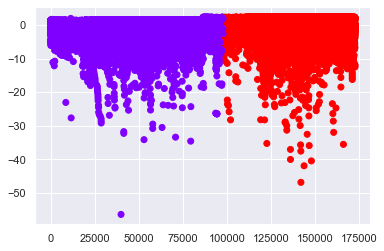

In [463]:
def plot_classifier_output(classifier, X):
    
    plt.scatter(X[:,0],X[:,1], c=classifier.kmeans.labels_, cmap='rainbow')

plot_classifier_output(sklearn_model, X_train)

### Predictions

In [464]:
def generate_predictions(classifier, data):
    
    y_hat = classifier.predict(data)
    return y_hat

In [465]:
%time
sklearn_preds =  generate_predictions(sklearn_model, X_test)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


In [466]:
%time
faiss_preds =  generate_predictions(faiss_model, X_test)

CPU times: user 39 µs, sys: 5 µs, total: 44 µs
Wall time: 7.15 µs


### Evaluation

In [467]:
print(classification_report(y_test, sklearn_preds))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70     56867
           1       0.00      0.36      0.00        95

    accuracy                           0.54     56962
   macro avg       0.50      0.45      0.35     56962
weighted avg       1.00      0.54      0.70     56962



In [468]:
print(classification_report(y_test, faiss_preds))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70     56867
           1       0.00      0.36      0.00        95

    accuracy                           0.54     56962
   macro avg       0.50      0.45      0.35     56962
weighted avg       1.00      0.54      0.70     56962



### Further Improvements using PCA/TSNE

In [ ]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(X)

# Compute the clusters
sklearn_tsne = SklearnKMeans(n_clusters=2)
sklearn_tsne.fit(X)
clusters = sklearn_tsne.predict(X)


# Permute the labels
labels_pred = np.zeros_like(clusters)

for i in range(10):
    mask = (clusters == i)
    labels_pred[mask] = mode(labels[mask])[0]

# Compute the accuracy
accuracy_score(labels, labels_pred)

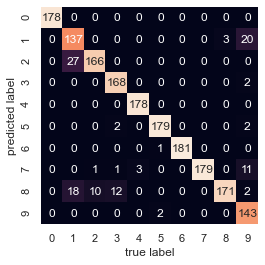

In [260]:
mat = confusion_matrix(labels, labels_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(labels),
            yticklabels=np.unique(labels))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [291]:
unique_labels = np.unique(labels)
print(classification_report(labels, labels_pred, labels=unique_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       0.86      0.75      0.80       182
           2       0.86      0.94      0.90       177
           3       0.99      0.92      0.95       183
           4       1.00      0.98      0.99       181
           5       0.98      0.98      0.98       182
           6       0.99      1.00      1.00       181
           7       0.92      1.00      0.96       179
           8       0.80      0.98      0.88       174
           9       0.99      0.79      0.88       180

    accuracy                           0.93      1797
   macro avg       0.94      0.94      0.93      1797
weighted avg       0.94      0.93      0.93      1797



10